# A Comparison of Surrogate Gradient Functions

In [1]:
# JAX imports
import os

import jax

import spyx
import spyx.nn as snn

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".80"
# implement our SNN in DeepMind's Haiku
import haiku as hk
import jmp

# rendering tools
import matplotlib.pyplot as plt
import numpy as np

# for surrogate loss training.
import optax
from jax import numpy as jnp
from jax_tqdm import scan_tqdm
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

%matplotlib notebook

## Set Mixed Precision Policy

In [2]:
policy = jmp.get_policy('half')


hk.mixed_precision.set_policy(hk.Linear, policy)
hk.mixed_precision.set_policy(snn.LIF, policy)
hk.mixed_precision.set_policy(snn.LI, policy)

## Data Loading

In [3]:
shd_dl = spyx.loaders.SHD_loader(256,128,256)

In [4]:
key = jax.random.PRNGKey(0)
x, y = shd_dl.train_epoch(key)

<IPython.core.display.Javascript object>


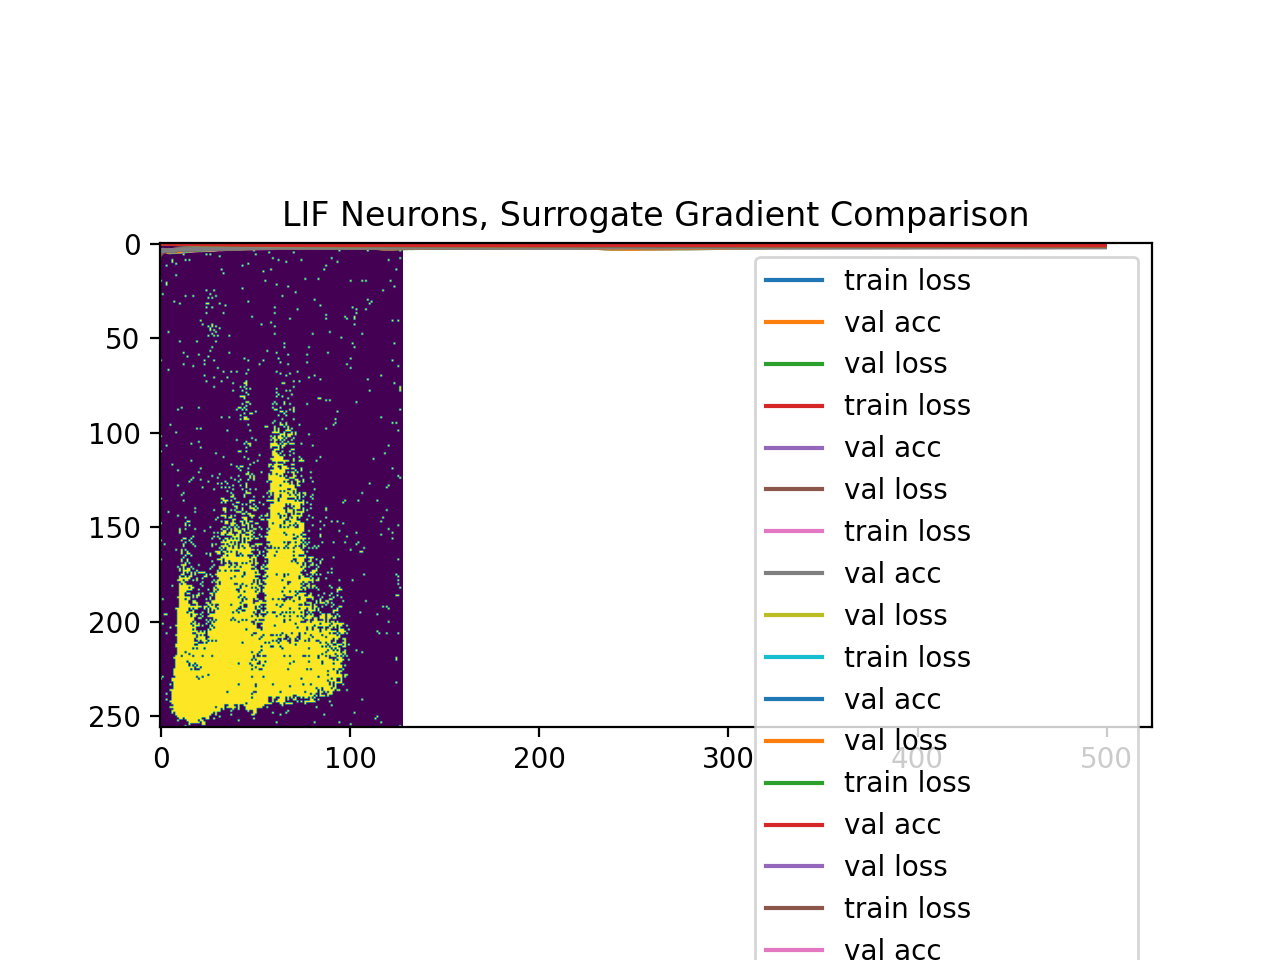

In [5]:
plt.imshow(np.unpackbits(x[0][69], axis=0).T)
plt.show()

In [6]:
y.shape

(25, 256)

## SNN

In [7]:
def arctan_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.arctan()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [8]:
def superspike_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.superspike()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.superspike()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [9]:
def tanh_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.tanh()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.tanh()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [10]:
def boxcar_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.boxcar()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.boxcar()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [11]:
def triangular_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,), activation=spyx.axn.triangular()),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,), activation=spyx.axn.triangular()),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [12]:
def ste_snn(x):
    
    x = hk.BatchApply(hk.Linear(128, with_bias=False))(x)
    
    core = hk.DeepRNN([
        snn.LIF((128,)),
        hk.Linear(128, with_bias=False),
        snn.LIF((128,)),
        hk.Linear(20, with_bias=False),
        snn.LI((20,))
    ])
    
    # static unroll for maximum performance
    spikes, V = hk.dynamic_unroll(core, x, core.initial_state(x.shape[0]), time_major=False, unroll=10)
    
    return spikes, V

In [13]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
arctan_SNN = hk.without_apply_rng(hk.transform(arctan_snn))
arctan_params = arctan_SNN.init(rng=key, x=x[0])

In [14]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
superspike_SNN = hk.without_apply_rng(hk.transform(superspike_snn))
superspike_params = superspike_SNN.init(rng=key, x=x[0])

In [15]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
tanh_SNN = hk.without_apply_rng(hk.transform(tanh_snn))
tanh_params = tanh_SNN.init(rng=key, x=x[0])

In [16]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
boxcar_SNN = hk.without_apply_rng(hk.transform(boxcar_snn))
boxcar_params = boxcar_SNN.init(rng=key, x=x[0])

In [17]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
triangular_SNN = hk.without_apply_rng(hk.transform(triangular_snn))
triangular_params = triangular_SNN.init(rng=key, x=x[0])

In [18]:
key = jax.random.PRNGKey(0)
# Since there's nothing stochastic about the network, we can avoid using an RNG as a param!
ste_SNN = hk.without_apply_rng(hk.transform(ste_snn))
ste_params = ste_SNN.init(rng=key, x=x[0])

## Gradient Descent

In [19]:
def gd(SNN, params, dl, epochs=500, schedule=3e-4):
    
    aug = spyx.data.shift_augment(max_shift=16)
    
    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()
    
    opt = optax.chain(
        optax.centralize(),
        optax.lion(learning_rate=schedule)
    )
    # create and initialize the optimizer
    opt_state = opt.init(params)
    grad_params = params
        
    # define and compile our eval function that computes the loss for our SNN
    @jax.jit
    def net_eval(weights, events, targets):
        readout = SNN.apply(weights, events)
        traces, V_f = readout
        return Loss(traces, targets)
        
    # Use JAX to create a function that calculates the loss and the gradient!
    surrogate_grad = jax.value_and_grad(net_eval) 
        
    rng = jax.random.PRNGKey(0)        
    
    # compile the meat of our training loop for speed
    @jax.jit
    def train_step(state, data):
        grad_params, opt_state = state
        events, targets = data # fix this
        events = jnp.unpackbits(events, axis=1) # decompress temporal axis
        # compute loss and gradient
        loss, grads = surrogate_grad(grad_params, aug(events, jax.random.fold_in(rng,jnp.sum(targets))), targets)
        # generate updates based on the gradients and optimizer
        updates, opt_state = opt.update(grads, opt_state, grad_params)
        # return the updated parameters
        new_state = [optax.apply_updates(grad_params, updates), opt_state]
        return new_state, loss
    
    # For validation epochs, do the same as before but compute the
    # accuracy, predictions and losses (no gradients needed)
    @jax.jit
    def eval_step(grad_params, data):
        events, targets = data # fix
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(grad_params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return grad_params, jnp.array([acc, loss])
        
    
    val_data = dl.val_epoch()
    
    # Here's the start of our training loop!
    @scan_tqdm(epochs)
    def epoch(epoch_state, epoch_num):
        curr_params, curr_opt_state = epoch_state
        
        shuffle_rng = jax.random.fold_in(rng, epoch_num)
        train_data = dl.train_epoch(shuffle_rng)
        
        # train epoch
        end_state, train_loss = jax.lax.scan(
            train_step,# func
            [curr_params, curr_opt_state],# init
            train_data,# xs
            train_data.obs.shape[0]# len
        )
        
        new_params, _ = end_state
            
        # val epoch
        _, val_metrics = jax.lax.scan(
            eval_step,# func
            new_params,# init
            val_data,# xs
            val_data.obs.shape[0]# len
        )

        
        return end_state, jnp.concatenate([jnp.expand_dims(jnp.mean(train_loss),0), jnp.mean(val_metrics, axis=0)])
    # end epoch
    
    # epoch loop
    final_state, metrics = jax.lax.scan(
        epoch,
        [grad_params, opt_state], # metric arrays
        jnp.arange(epochs), # 
        epochs # len of loop
    )
    
    final_params, _ = final_state
    
                
    # return our final, optimized network.       
    return final_params, metrics

In [20]:
def test_gd(SNN, params, dl):

    Loss = spyx.fn.integral_crossentropy()
    Acc = spyx.fn.integral_accuracy()
    
    @jax.jit
    def test_step(params, data):
        events, targets = data
        events = jnp.unpackbits(events, axis=1)
        readout = SNN.apply(params, events)
        traces, V_f = readout
        acc, pred = Acc(traces, targets)
        loss = Loss(traces, targets)
        return params, [acc, loss, pred, targets]
    
    test_data = dl.test_epoch()
    
    _, test_metrics = jax.lax.scan(
            test_step,# func
            params,# init
            test_data,# xs
            test_data.obs.shape[0]# len
    )
    
    acc = jnp.mean(test_metrics[0])
    loss = jnp.mean(test_metrics[1])
    preds = jnp.array(test_metrics[2]).flatten()
    tgts = jnp.array(test_metrics[3]).flatten()
    return acc, loss, preds, tgts

## Training Time

## Arctan

In [21]:
arctan_grad_params, arctan_metrics = gd(arctan_SNN, arctan_params, 
                                        shd_dl, epochs=500, schedule=1e-4) 
# 1:08

  0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*arctan_metrics[-1]))

Performance: train_loss=1.735169529914856, val_acc=0.9127604365348816, val_loss=1.7500375509262085


In [23]:
plt.plot(arctan_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, Arctan Surrogate")
plt.legend()
plt.show()

## Superspike

First experiment was using the same learning rate schedule as arctan.

In [24]:
superspike_grad_params, superspike_metrics = gd(superspike_SNN,
                                     superspike_params,
                                     shd_dl, epochs=500,
                                     schedule=1e-4) #1:08

  0%|          | 0/500 [00:00<?, ?it/s]

In [25]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*superspike_metrics[-1]))

Performance: train_loss=1.7723969221115112, val_acc=0.904296875, val_loss=1.776943564414978


In [26]:
plt.plot(superspike_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, SuperSpike Surrogate")
plt.legend()
plt.show()

## Tanh

In [27]:
tanh_grad_params, tanh_metrics = gd(tanh_SNN, tanh_params, shd_dl, 500, 1.5e-4) #1:08

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*tanh_metrics[-1]))

Performance: train_loss=1.7103031873703003, val_acc=0.9309896230697632, val_loss=1.7181179523468018


In [29]:
plt.plot(tanh_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, Tanh Surrogate")
plt.legend()
plt.show()

## Boxcar

In [30]:
boxcar_grad_params, boxcar_metrics = gd(boxcar_SNN, boxcar_params, shd_dl, 500, 2e-4) #1:07

  0%|          | 0/500 [00:00<?, ?it/s]

In [31]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*boxcar_metrics[-1]))

Performance: train_loss=1.6953572034835815, val_acc=0.93359375, val_loss=1.7078595161437988


In [32]:
plt.plot(boxcar_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, Boxcar Surrogate")
plt.legend()
plt.show()

## Triangular

In [33]:
triangular_grad_params, triangular_metrics = gd(triangular_SNN,
                                                triangular_params,
                                                shd_dl, 500, 1e-4) #1:07

  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*triangular_metrics[-1]))

Performance: train_loss=1.7459193468093872, val_acc=0.9368489980697632, val_loss=1.7430299520492554


In [35]:
plt.plot(triangular_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, Triangular Surrogate")
plt.legend()
plt.show()

## Straight Through Estimator

In [36]:
ste_grad_params, ste_metrics = gd(ste_SNN,
                                  ste_params,
                                  shd_dl, 500, 7e-5) #1:00

  0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
print("Performance: train_loss={}, val_acc={}, val_loss={}".format(*ste_metrics[-1]))

Performance: train_loss=1.764548897743225, val_acc=0.916015625, val_loss=1.7642936706542969


In [38]:
plt.plot(ste_metrics, label=["train loss", "val acc", "val loss"])
plt.title("LIF Neurons, S.T.E. Surrogate")
plt.legend()
plt.show()

## Evaluation Time

Now we'll run the network on the test set and see what happens:

In [39]:
plt.plot(superspike_metrics[:,1], label="SuperSpike Val. Acc.")
plt.plot(arctan_metrics[:,1], label="Arctan Val. Acc.")
plt.plot(tanh_metrics[:,1], label="Tanh Val. Acc.")
plt.plot(boxcar_metrics[:,1], label="Boxcar Val. Acc.")
plt.plot(triangular_metrics[:,1], label="Triangular Val. Acc.")
plt.plot(ste_metrics[:,1], label="S.T.E Val. Acc.")

# need to fix line labeling to make easier to distinguish.
plt.title("LIF Neurons, Surrogate Gradient Comparison")
plt.legend()
plt.show()

In [41]:
thetas = [arctan_grad_params, tanh_grad_params,
          superspike_grad_params, boxcar_grad_params, triangular_grad_params,
          ste_grad_params]

spike_nets = [arctan_SNN, tanh_SNN, superspike_SNN,
              boxcar_SNN, triangular_SNN, ste_SNN]

names = ["Arctan", "Tanh", "SuperSpike", "Boxcar", "Triangular", "S.T.E."]

for name, net, theta in zip(names, spike_nets, thetas):
    acc, loss, preds, tgts = test_gd(net, theta, shd_dl)
    print(name, "Accuracy:", acc, "Loss:", loss)

Arctan Accuracy: 0.8339844 Loss: 1.8657817
Tanh Accuracy: 0.8378906 Loss: 1.8613833
SuperSpike Accuracy: 0.83447266 Loss: 1.8981744
Boxcar Accuracy: 0.85791016 Loss: 1.8321633
Triangular Accuracy: 0.80029297 Loss: 1.9189148
S.T.E. Accuracy: 0.83154297 Loss: 1.8875296


In [44]:
acc, loss, preds, tgts = test_gd(boxcar_SNN, boxcar_grad_params, shd_dl)

<IPython.core.display.Javascript object>


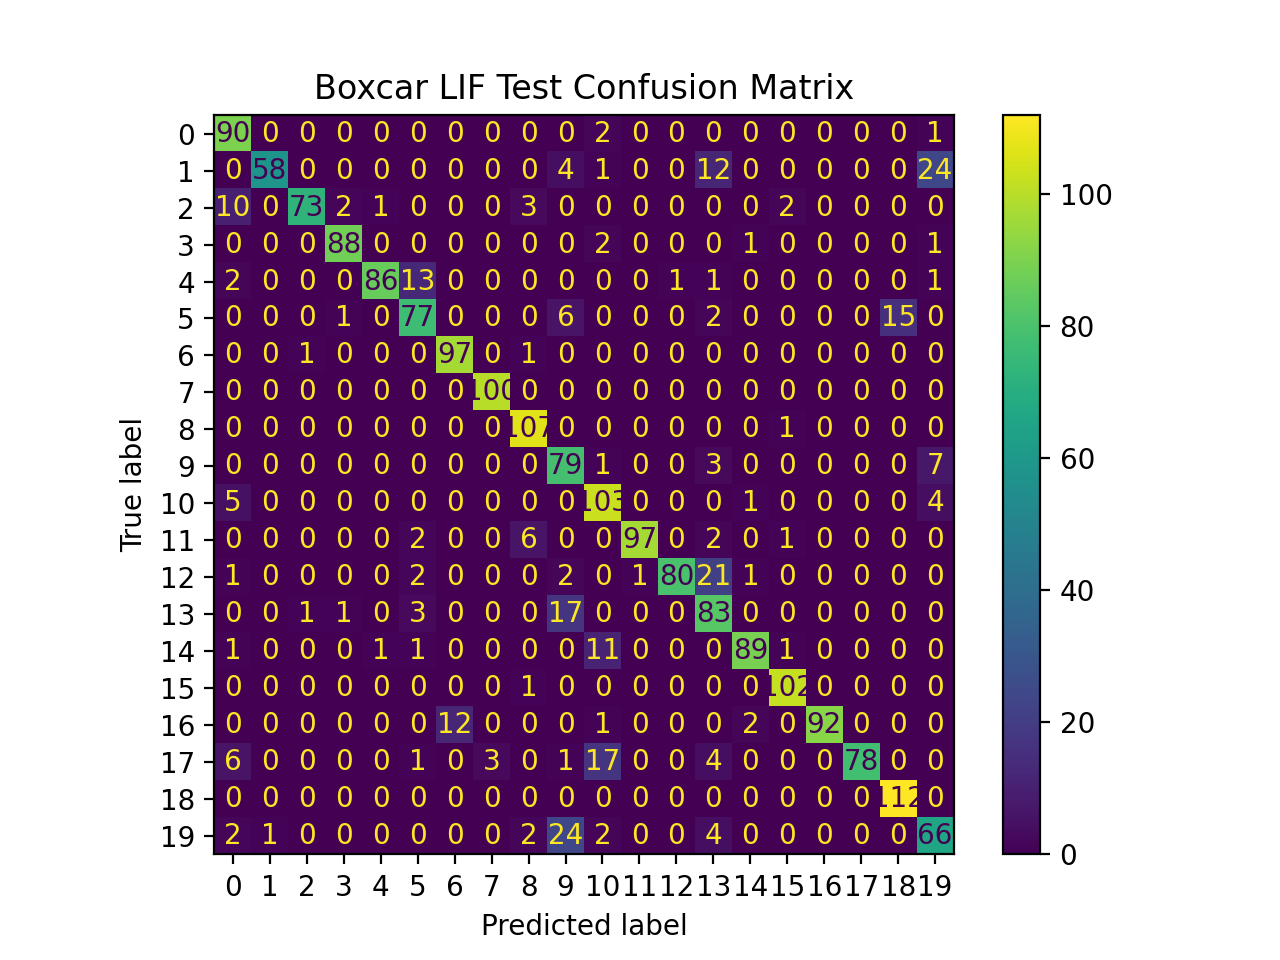

In [45]:
cm = confusion_matrix(tgts, preds)
ConfusionMatrixDisplay(cm).plot()
plt.title("Boxcar LIF Test Confusion Matrix")
plt.show()